In [1]:
from mine_cliques import *
import pandas as pd
from collections import defaultdict
import networkx as nx

In [2]:
datasets = ["karate","deezer_HR", "deezer_HU", "deezer_RO","tw_musae_DE",
            "tw_musae_ENGB","tw_musae_FR","lastfm_asia","fb_ath",
            "fb_pol","phonecalls", "facebook_sc"]

In [6]:
def WL_take_10(G, k_max=10, verbosity=0):
    for i in G.nodes:
        G.nodes[i]["color_0"]=0
    
    meanings=[]
    last_labeling=[0 for _ in range(len(G.nodes))]
    for k in range(k_max):
        if verbosity>0:
            print(k)
        colors = {}
        labeling = []
        for i in G.nodes:
            color_meaning = tuple(sorted([G.nodes[j][f"color_{k}"] for j in G.neighbors(i)])[:10])
            #print(color_meaning)
            if color_meaning in colors:
                color = colors[color_meaning]
            else:
                color = len(colors)
                colors[color_meaning]=color
            labeling.append(color)
            G.nodes[i][f"color_{k+1}"]=color

        meanings.append(colors)
        #print(labeling)
        #print(last_labeling)
        if verbosity>0:
            print("number of colors", len(colors))
        if len(set(labeling)) == len(set(last_labeling)):
            if verbosity>0:
                print(f"converged in {k} iterations")
            break
        if labelings_are_equivalent(labeling, last_labeling):
            if verbosity>0:
                print(f"converged in {k} iterations")
            break
        last_labeling=labeling

In [7]:
def compute_on_all_Graphs(func, verbosity=0):
    Graphs = []
    for dataset in datasets:
        if verbosity>0:
            print(dataset)
        vals =calc_all_vals(dataset)
        edges = vals[0][0][2]
        G = nx.Graph(edges)
        func(G)
        if verbosity>0:
            print(len(G.edges))
        Graphs.append(G)
    return Graphs

In [8]:
def get_colors_for_graphs(Graphs):
    n_colors=[]
    for G in Graphs:
        k_max=10
        G_colors=[]
        for k in range(k_max):
            colors = set()
            for i in G.nodes:
                try:
                    colors.add(G.nodes[i][f'color_{k}'])
                except KeyError:
                    k_max=k
                    break
            if k==k_max:
                break
            G_colors.append(len(colors))
        n_colors.append(G_colors)
    return n_colors

# Look at how WL converges

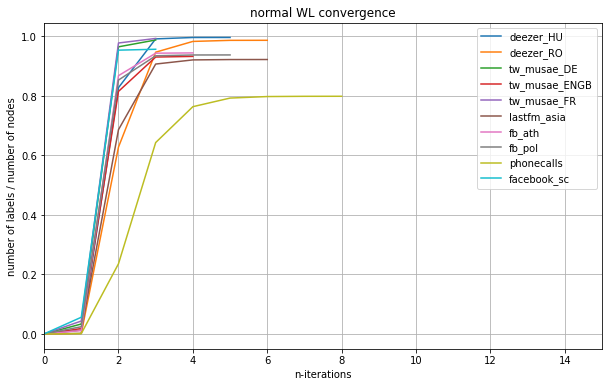

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
Graphs = compute_on_all_Graphs(WL)
for G, arr, dataset in zip(Graphs, get_colors_for_graphs(Graphs), datasets):
    if dataset in ["karate", "deezer_HR"]:
        continue
    plt.plot(np.array(arr[:-1])/len(G.nodes), label=dataset)
plt.xlim([0,15])
plt.legend()
plt.title("normal WL convergence")
plt.xlabel("n-iterations")
plt.ylabel("number of labels / number of nodes")
plt.grid()

# Look at how WL converges if we only consider 10 nodes in the multiset

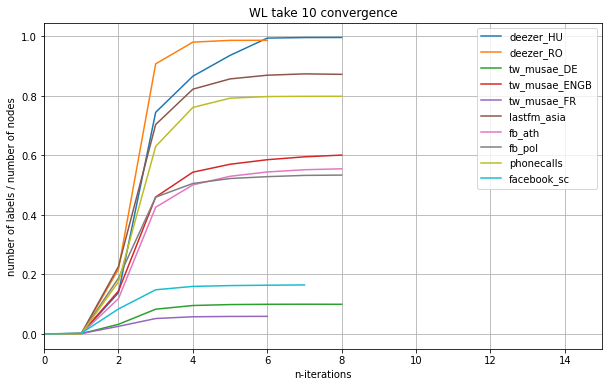

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
Graphs = compute_on_all_Graphs(WL_take_10)
for G, arr, dataset in zip(Graphs, get_colors_for_graphs(Graphs), datasets):
    if dataset in ["karate", "deezer_HR"]:
        continue
    plt.plot(np.array(arr[:-1])/len(G.nodes), label=dataset)
plt.xlim([0,15])
plt.legend()
plt.xlabel("n-iterations")
plt.title("WL take 10 convergence")
plt.ylabel("number of labels / number of nodes")
plt.grid()

## Prelim conclusion

It seems, that the WL algorithm converges rather quickly on real word data/ converges with very many unique colors. The latter is a big problem because the this renders generating similar network nearly useless. To combat this issue we will make attempts in which we do not allow colors to become unique in the first place.

# Non unique WL

In this approach we no longer split colors if this would result in colors with fewer then `min_size_of_color` nodes for that color. This is achieved by associating specific meanings of color with one another. For example the top 10 hub nodes in a social network are all considered equal even though they are in principle unique.

In [11]:
import networkx as nx
pos = nx.spring_layout(nx.karate_club_graph(), seed=3)

In [12]:
from collections import Counter
def find_splits(total_counts, nodes_with_color, k_min, verbosity=0):
    if verbosity>2:
        #print("color", color)
        print("total_counts",total_counts)
        print("nodes_with_color", nodes_with_color)
        #print("affected2", sorted(list(affected_nodes.values())))
        #print("prev", prev_color)
    if total_counts < k_min*2:
        # We cannot change the colors at all so all are mapped to the same
        d = {x : 0 for x in nodes_with_color.keys()}
        d[0]=0
        return d  

    counts_per_group = Counter(nodes_with_color)
    changed_counts = sum(counts_per_group.values())#starting pyhton 3.10 just .total()

    #print("count_per_count", counts_per_group)
    zero_counts = total_counts - changed_counts
    allowed_changes = [(count, group) for group, count in counts_per_group.items()]
    allowed_changes.append((zero_counts,0))
    allowed_changes = sorted(allowed_changes, reverse=True)
    #print("allowed", allowed_changes)

    new_colors = []

    remaining_counts = total_counts
    group_assignments = {}
    set_id=1
    i=0
    while i < len(allowed_changes):
        current_set = []
        count_this_set = 0
        # add nodes to this the set (new color) until either this set exceeds k_min
        # or we can't fill the last color with enough nodes
        while ((count_this_set < k_min) or (remaining_counts < k_min)) and i < len(allowed_changes):
            count, group = allowed_changes[i]
            if verbosity>4:
                print("group count", group, count)
            current_set.append(group)
            remaining_counts -= count
            count_this_set += count
            i+=1
        while remaining_counts < k_min and i < len(allowed_changes): # add remaining
            count, group = allowed_changes[i]
            current_set.append(group)
        if verbosity>4:
            print(current_set, count_this_set)
        if 0 in current_set: # 0 is a special indicator meaning "color is unchanged"
            for count in current_set:
                group_assignments[count]=0
        else:
            for count in current_set:
                group_assignments[count]=set_id
            set_id += 1
    
    return group_assignments


#count_by_color1 = {0:15}
#affected_nodes1 = {0:20, 1:100, 3:4, 4:1, 5:1}
#prev_color1 = [1,2,0,0,0,0]
#find_splits(0, count_by_color1, affected_nodes1, prev_color1, 3)

In [13]:
def WL_hacked(G, k_min, k_max, verbosity=0):
    for i in G.nodes:
        G.nodes[i]["color_0"]=0
    last_colors = {key:0 for key in G.nodes}
    color_map={}
    inv_color_map={}
    new_color_index = 0
    for k in range(k_max):
        colors_to_nodes = defaultdict(set)
        for color, node in zip(last_colors.values(), G.nodes):
            colors_to_nodes[color].add(node)
            
        print(k)
        colors = {}
        
        colourings = []
        #count_by_color = Counter()
        new_color_list = last_colors.copy()
        new_colors = {}
        # find colors that are affected by the split
        receiving_colors = set(colors_to_nodes.keys())#last_colors[node] for node in affected_nodes.keys())
        for sending_color, nodes in colors_to_nodes.items():
            if verbosity > 0:
                print("sending color", sending_color)
            # propagate all labels of one colour
            affected_nodes = Counter()
            for i in nodes:
                for neigh in G.neighbors(i):
                    affected_nodes[neigh] += 1


            count_per_color = Counter(new_color_list.values())
            for receiving_color in receiving_colors:
                if verbosity > 1:
                    print("colors", sending_color, receiving_color)
                splits = find_splits(count_per_color[receiving_color], [affected_nodes[x] for  x in colors_to_nodes[receiving_color]], k_min, verbosity=verbosity)
                if verbosity>4:
                    print(splits, "\r\n")
                if all(x==0 for x in splits.values()): # all will keep colors
                    continue
                if len(splits)==1: # nothing to split
                    continue
                print(len(colors_to_nodes[receiving_color]))
                for node in colors_to_nodes[receiving_color]:
                    count = affected_nodes[node]
                    if new_color_list[node] != receiving_color:
                        continue
                    if splits[count] == 0:
                        # assign old color
                        selected_color = receiving_color
                    else:
                        new_assignment = (new_color_list[node], (sending_color, receiving_color, splits[count]))
                        if  new_assignment in color_map: # color was already assigned
                            selected_color = color_map[new_assignment]
                        else: # assign new color
                            new_color_index +=1
                            selected_color =  new_color_index
                            color_map[new_assignment] = selected_color

                    new_colors[node] = selected_color
                for node_id, new_color in new_colors.items():
                    G.nodes[node_id][f"color_{k}_{sending_color}"]=new_color

                for node_id, new_color in new_colors.items():
                    last_color = new_color_list[node_id]
                    if last_color != new_color:
                        count_per_color[last_color]-=1
                        count_per_color[new_color]+=1
                        assert new_color >= last_color
                        if verbosity >4:
                            print("<<<<<changed", new_color_list[node_id], "to", new_color)
                    new_color_list[node_id] =  new_color
        print("number of colors", len(set(new_color_list.values())))
        if verbosity>3:
            print(last_colors, new_color_list)
        if labelings_are_equivalent(last_colors, new_color_list):
            print(f"converged in {k} iterations")
            break
        last_colors=new_color_list
    if k==k_max:
        print("max number of iterations reached")
    return last_colors, color_map

In [14]:
import numpy as np

In [15]:
def undo_sort(arg_sort_result, sorted_result):
    i_rev = np.zeros_like(arg_sort_result)
    i_rev[arg_sort_result]=np.arange(len(i_rev))
    return sorted_result[i_rev]

def get_new_colors_with_min_size(tmp_multisets, min_size_of_color):

    # convert meanings into numpy array so we can argsort
    arr_multisets = np.empty(shape=(len(tmp_multisets),), dtype=object)
    arr_multisets[:]=tmp_multisets

    # argsort result (could also do prefix tree here)
    argsort_result = np.argsort(arr_multisets, axis=0)
    multisets_sorted = arr_multisets[argsort_result]

    # compute splits
    splits = get_splits2(multisets_sorted, min_size_of_color)

    # convert splits to color assignments
    color_assignments_sorted = np.zeros(len(multisets_sorted), dtype=int)
    for c, split in enumerate(splits):
        color_assignments_sorted[split]=c
    colors_original_order = undo_sort(argsort_result, color_assignments_sorted)
    return colors_original_order

In [16]:
def len_for_slice(s, l):
    return len(range(*s.indices(len(l))))
def get_splits2(v, min_size_of_color, depth=0, current_slice=slice(None)):
    """Takes a list/array of tuples of tuples"""
    assert current_slice.step is None, "Can't handle steps"
    if not current_slice.stop is None and not current_slice.start is None and current_slice.stop - current_slice.start < 2*min_size_of_color:
        return [current_slice]
        
    C = Counter(x[depth] if len(x)>depth else tuple()  for x in v[current_slice] )
    total = len_for_slice(current_slice, v)
    
    # can choose another order here!
    ordered_keys = sorted(list(C.keys()))
    remaining_count = total
    last_i=current_slice.start
    if last_i is None:
        last_i = 0
    result = []
    running_count=0
    for key in ordered_keys:
        count = C[key]
        #print("  "*depth+"key count", key, count)
        #print("last_i", last_i)
        # recusively call this function with new range
        if ((total - count - running_count) >= min_size_of_color) or depth==0:
            if running_count + count >= min_size_of_color:
                tmp_results = get_splits2(v,
                                          min_size_of_color,
                                          depth=depth+1,
                                          current_slice=slice(last_i, last_i+count+running_count))
                #for s in tmp_results:
                #    the_len = len_for_slice(s, v)
                last_i += count+running_count
                total -= count+running_count
                result.extend(tmp_results)
                running_count = 0
            else:
                running_count+=count
                continue
        else:
            result.append(slice(last_i, current_slice.stop))
            break
    return result

#splits= get_splits2(v, 3)
#display(splits)
#for split in splits:
#    print(Counter(v[split]))

In [17]:
def WL_hacked2(G, min_size_of_color, k_max, verbosity ):
    for i in G.nodes:
        G.nodes[i]["color_0"]=0
    
    meanings=[]
    last_coloring=[0 for _ in range(len(G.nodes))]
    for k in range(k_max):
        if verbosity > 0:
            print(k)
        tmp_multisets  = []
        for index,i in enumerate(G.nodes):
            color_meaning = tuple(Counter([G.nodes[j][f"color_{k}"] for j in G.neighbors(i)]).most_common())
            tmp_multisets.append((G.nodes[i][f"color_{k}"], *color_meaning))
            
        colors = get_new_colors_with_min_size(tmp_multisets, min_size_of_color)
        
        # store "meanings" of colors
        meanings_level = defaultdict(set)
        for multiset, color in zip(tmp_multisets, colors):
            meanings_level[color].add(multiset)
        
        # store colors in nodes (networkx way)
        for color, node_id in zip(colors, G.nodes):
            G.nodes[node_id][f"color_{k+1}"]=color

        meanings.append(meanings_level)
        if verbosity>0:
            print("number of colors", len(meanings_level))
        if labelings_are_equivalent(colors, last_coloring):
            if verbosity>0:
                print(f"converged in {k} iterations")
            break
        last_coloring=colors
    return last_coloring, meanings

In [18]:
v=[(0, (0, 1)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 2)), (0, (0, 3)), (0, (0, 3)), (0, (0, 3)), (0, (0, 3)), (0, (0, 3)), (0, (0, 3)), (0, (0, 4)), (0, (0, 4)), (0, (0, 4)), (0, (0, 4)), (0, (0, 4)), (0, (0, 4)), (0, (0, 5)), (0, (0, 5)), (0, (0, 5)), (0, (0, 6)), (0, (0, 6)), (0, (0, 9)), (0, (0, 10)), (0, (0, 12)), (0, (0, 16)), (0, (0, 17))]

## Visualize the non unique conversion for the Karate Club Graph

In [19]:
import networkx as nx
min_count = 3
G = nx.karate_club_graph()
cm,cp=WL_hacked2(G, min_count, 3, verbosity=5)

0
number of colors 6
1
number of colors 7
2
number of colors 7
converged in 2 iterations


0
number of colors 7
1
number of colors 13
2
number of colors 13
converged in 2 iterations
Counter({3: 5, 5: 4, 12: 3, 9: 3, 2: 3, 11: 2, 10: 2, 7: 2, 6: 2, 1: 2, 0: 2, 4: 2, 8: 2})


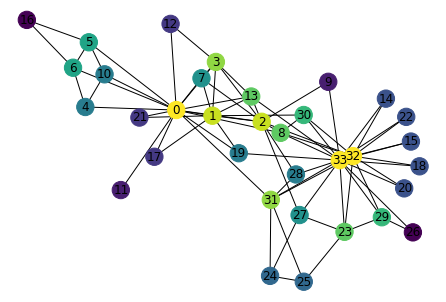

In [20]:
import networkx as nx
min_count = 2
G = nx.karate_club_graph()
cm,cp=WL_hacked2(G, min_count, 3, verbosity=5)
color_map = [cm[x] for x in G.nodes]
print(Counter(color_map))
nx.draw(G, node_color=color_map, with_labels=True, pos=pos)
plt.show()

0
number of colors 5
1
number of colors 6
2
number of colors 6
converged in 2 iterations
Counter({1: 8, 2: 6, 3: 6, 5: 5, 4: 5, 0: 4})


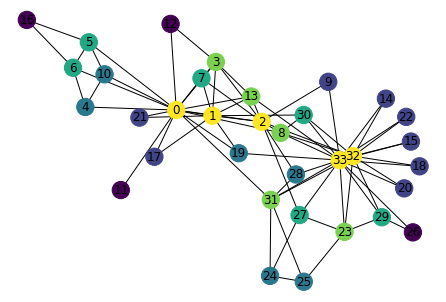

In [21]:
min_count = 4
G = nx.karate_club_graph()
cm,cp=WL_hacked2(G, min_count, 3, verbosity=5)
color_map = [cm[x] for x in G.nodes]
print(Counter(color_map))
nx.draw(G, node_color=color_map, with_labels=True, pos=pos)
plt.show()

In [22]:
#print(Counter(cm.values()))
#assert all(x>=min_count for x in  Counter(cm.values()).values())

## Look at convergence of of non unique WL

In [23]:
import functools

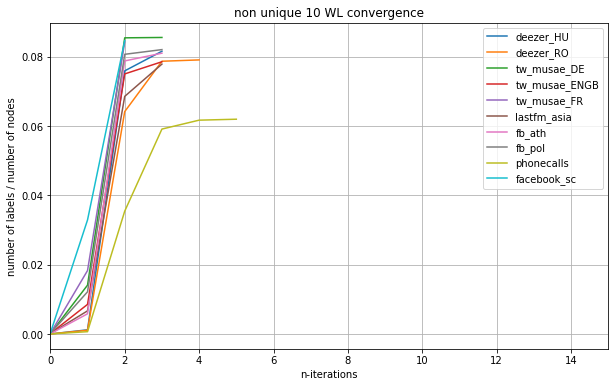

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
Graphs = compute_on_all_Graphs(functools.partial(WL_hacked2, min_size_of_color=10, k_max=10, verbosity=0))
for G, arr, dataset in zip(Graphs, get_colors_for_graphs(Graphs), datasets):
    if dataset in ["karate", "deezer_HR"]:
        continue
    plt.plot(np.array(arr[:-1])/len(G.nodes), label=dataset)
plt.xlim([0,15])
plt.legend()
plt.xlabel("n-iterations")
plt.title("non unique 10 WL convergence")
plt.ylabel("number of labels / number of nodes")
plt.grid()

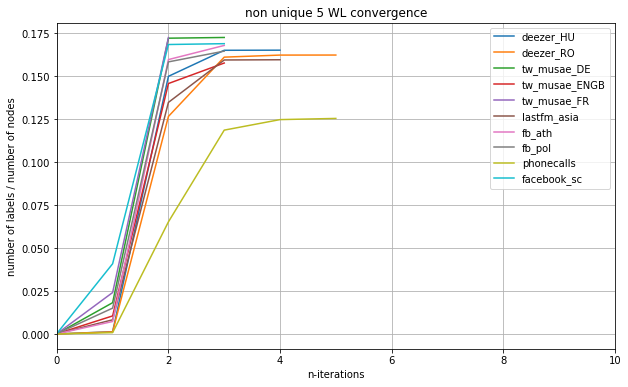

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
Graphs = compute_on_all_Graphs(functools.partial(WL_hacked2, min_size_of_color=5, k_max=10, verbosity=0))
for G, arr, dataset in zip(Graphs, get_colors_for_graphs(Graphs), datasets):
    if dataset in ["karate", "deezer_HR"]:
        continue
    plt.plot(np.array(arr[:-1])/len(G.nodes), label=dataset)
plt.xlim([0,10])
plt.legend()
plt.xlabel("n-iterations")
plt.title("non unique 5 WL convergence")
plt.ylabel("number of labels / number of nodes")
plt.grid()

## Comment
Still very fast convergence but look at the y-axis: We have just very few colors which implies that randomization could work for these networks.

### Todo
Change (randomize?) the order in which we aggregate the colors. This could potentially further split the colors apart. Not sure how much this would improve the above because the number of colors is limited to 10%(1/10) or 20%(1/5) of original colors.

# Interpolate between iterations

Usually the iterations are fixed but we can get intermediate results by randomly sampling only a subset of the previous colors this will give intermediate steps between the different iterations. These can be used to (probably) generate colorings with a wider range of colors.